In [85]:
import os
print("Working at: \n {}".format(os.getcwd()))

Working at: 
 /Users/danbiderman/Dropbox/Columbia/1.Dan/Research/Paninski/3D-Animal-Pose/PPCA


In [86]:
import numpy as np
import h5py # TODO: not currently in our requirements.yml
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm # in the .py script of the LinearGaussian class, no need for notebook
from ipywidgets import IntProgress

from utils.PPCA_utils import make_meshgrid, \
                        mahalanobis_distance, \
                        clean_nans, \
                        undo_nan_cleanup, \
                        extract_missing_ind_pairs, \
                        extract_bp_idx, \
                        get_PCA_params, \
                        plot_coords_views, \
                        create_ind_list, \
                        make_arr_for_pca, \
                        set_or_open_folder, \
                        infer_and_predict, \
                        reshape_posts_or_preds, \
                        flag_missing_obs, \
                        compute_per_view_empirical_maha, \
                        compute_percentile_in_list
from utils.PPCA_plot_utils import plot_participation_ratio, \
                                    compare_post_cov_norm, \
                                    set_legend_elements
from utils.TrackingPlottingClasses import Tracking_Video_Generator, \
                                        three_D_skeleton_plotter
from sklearn.decomposition import PCA # TODO: scikit-learn is not in our requirements.yml

In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define dataset
#### Currently supporting: Fish / IBL
set directories accordingly.

In [92]:
dataset = 'Fish' # Fish, IBL

In [91]:
plot_folder = set_or_open_folder(os.path.join("../../PCA_infill", 'figs', dataset))
image_folder = set_or_open_folder(os.path.join("../../PCA_infill", 'images', dataset))

The folder already exists at: ../../PCA_infill/figs/Fish
The folder already exists at: ../../PCA_infill/images/Fish


### Read and preprocess data
generate an array for PCA:


`arr_for_pca.shape: (num_views * 2, num_visible_body_parts * num_frames)`

In [5]:
file = h5py.File('../../Video_Datasets/IBL_for_PCA/hoferlab_SWC_015_2020-01-21-002_with_bad_frames.hdf5', 
               'r')

In [6]:
file["left"]["images"]

<HDF5 dataset "images": shape (400, 128, 160), type "|u1">

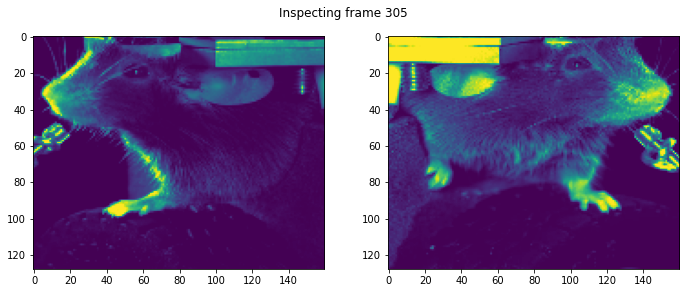

In [7]:
frame_inspect_ind = 305
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax = ax.flatten()
ax[0].imshow(file["left"]["images"][frame_inspect_ind,:,:])
ax[1].imshow(file["right"]["images"][frame_inspect_ind,:,:])
fig.suptitle("Inspecting frame %i" %frame_inspect_ind)
fig.tight_layout()

In [8]:
num_images = file["left"]["images"].shape[0]
bodypart_names = list(file["left"]["predictions"].keys())
num_bodyparts = len(bodypart_names)
view_names = ["left", "right"]

In [9]:
collapsed_mat = np.zeros((len(view_names), \
                          num_images, \
                          len(bodypart_names), \
                         2))
for i,view in enumerate(view_names):
    print("view: {}".format(view))
    for j,bp in enumerate(bodypart_names):
        print("bodypart: {}".format(bp))
        collapsed_mat[i, :, j, :] = file[view]["predictions"][bp]
collapsed_mat.shape

view: left
bodypart: nose_tip
bodypart: paw_l
bodypart: paw_r
view: right
bodypart: nose_tip
bodypart: paw_l
bodypart: paw_r


(2, 400, 3, 2)

In [10]:
# we were doing this previously (keeping it for now)
pts_2d = collapsed_mat.reshape(
        collapsed_mat.shape[0],
        collapsed_mat.shape[1] * collapsed_mat.shape[2],
        collapsed_mat.shape[3],
    )
print("pts_2d.shape: {}".format(pts_2d.shape))
pts_2d_filtered, clean_point_indices = clean_nans(pts_2d, True) 
print("pts_2d_filtered.shape: {}".format(pts_2d_filtered.shape))
arr_for_pca = np.concatenate((pts_2d_filtered[:,:,0], 
                            pts_2d_filtered[:,:,1]),  
                             axis=0) # squeeze (x,y) coords with views
print("arr_for_pca.shape: {}".format(arr_for_pca.shape))

pts_2d.shape: (2, 1200, 2)
pts_2d_filtered.shape: (2, 1099, 2)
arr_for_pca.shape: (4, 1099)


In [11]:
# for view in view_names:
#     for bp in bodypart_names:
#         if np.isnan(file[view]["predictions"][bp]).any():
#             print(view, bp)
#             nan_inds = np.where(np.isnan(file[view]["predictions"][bp]))
#             print(nan_inds[0][0])
#             plt.imshow(file[view]["images"][nan_inds[0][0], :,:])

## Vanilla PCA

In [12]:
pca = PCA(n_components=3, svd_solver='full')
pca.fit(arr_for_pca.T)

PCA(n_components=3, svd_solver='full')

In [13]:
print("PCA(%i)explained variance = %.3f" % (pca.n_components_, 
                                            np.sum(pca.explained_variance_ratio_)))

PCA(3)explained variance = 1.000


## Factor analysis / PPCA

In [14]:
arr_for_pca.T.shape

(1099, 4)

In [15]:
# run vanilla PCA keeping all 2K components
pca = PCA(n_components=arr_for_pca.T.shape[1], svd_solver='full')
pca.fit(arr_for_pca.T)
num_PCs = 3 # M

In [16]:
params = get_PCA_params(pca, num_PCs, arr_for_pca, "LP")

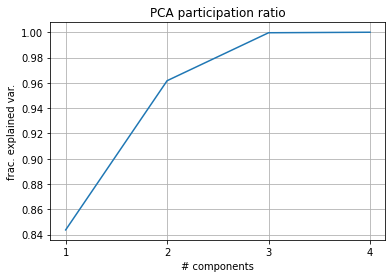

In [17]:
fig, ax = plt.subplots(1)
plot_participation_ratio(pca, ax=ax);
fig.savefig(os.path.join(plot_folder, 'participation_ratio.png'))

In [18]:
from LinearGaussianModel import LinearGaussianModel
LG_model = LinearGaussianModel(params['prior_mean'], 
                              0.5* params['prior_precision'], # TODO: the 0.5 is there just to inflate var. 
                               params['obs_projection'], 
                               params['obs_offset'], 
                               params['obs_precision'],
                              simplify_posterior=False)

In [19]:
# ToDo: verify, maybe not needed to do everything
arr_for_test = np.concatenate((collapsed_mat[:,:,:,0], 
                            collapsed_mat[:,:,:,1]),  
                             axis=0) # squeeze (x,y) coords with views
arr_squeezed = arr_for_test.reshape(len(view_names)*2,-1) # maybe redundant
print("arr_for_test.shape: {}".format(arr_for_test.shape))
print("arr_squeezed.shape: {}".format(arr_squeezed.shape))

arr_for_test.shape: (4, 400, 3)
arr_squeezed.shape: (4, 1200)


In [20]:
posteriors, predictions = infer_and_predict(LG_model, arr_squeezed)

In [21]:
# # loop over datapoints, compute posterior, and predict.
# post_mean_arr = np.zeros((num_PCs, arr_squeezed.shape[1]))
# post_cov_arr = np.zeros((num_PCs, num_PCs, arr_squeezed.shape[1]))
# pred_mean = np.zeros_like(arr_squeezed)
# pred_cov = np.zeros((arr_squeezed.shape[0],
#                      arr_squeezed.shape[0], 
#                      arr_squeezed.shape[1]))
# for i in range(arr_squeezed.shape[1]):
#     # compute posterior
#     post_mean, post_cov = LG_model.compute_posterior(arr_squeezed[:,i]) # a single frame and body part
#     post_mean_arr[:,i], post_cov_arr[:,:,i] = post_mean.squeeze(), post_cov
#     # predict
#     mean, cov = LG_model.predict(post_mean, post_cov, False)
#     pred_mean[:,i], pred_cov[:,:,i] = mean.squeeze(), cov
# assert((post_mean_arr - posteriors["mean"]<0.0000001).all())
# assert((post_cov_arr - posteriors["cov"]<0.0000001).all())
# assert((pred_mean - predictions["mean"]<0.0000001).all())
# assert((pred_cov - predictions["cov"]<0.0000001).all())

In [22]:
# pred_mean_reshaped = pred_mean.reshape(arr_for_test.shape)
# pred_cov_reshaped = pred_cov.reshape(arr_for_test.shape[0], 
#                                      arr_for_test.shape[0], 
#                                      arr_for_test.shape[1], 
#                                      arr_for_test.shape[2])
# assert((preds_reshaped["mean"] == pred_mean_reshaped).all())

In [23]:
preds_reshaped = reshape_posts_or_preds(predictions, *arr_for_test.shape)

In [24]:
# counts = np.arange(0,np.shape(arr_squeezed)[0] + 2, 2)
# strs = ["miss %i/%i" % (i, counts[-1]) for i in counts]
# strs

In [25]:
# missing_obs_bool = np.zeros((len(counts), np.shape(arr_squeezed)[-1]), dtype = bool)
# for i in range(len(counts)):
#     missing_obs_bool[i,:] = np.sum(np.isnan(arr_squeezed), axis=0)==counts[i]
# assert((np.sum(missing_obs_bool, axis=0)==1).all())
# assert((bool_test==missing_obs_bool).all())
# assert((counts_test==counts).all())

In [26]:
missing_obs_bool, counts = flag_missing_obs(arr_squeezed)

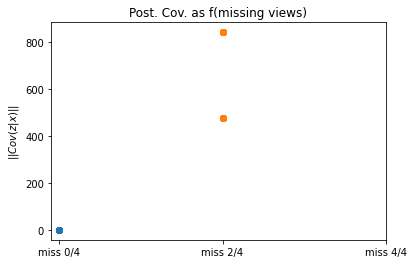

In [27]:
fig, ax = plt.subplots()
compare_post_cov_norm(posteriors, missing_obs_bool, counts, ax)
fig.savefig(plot_folder / 'post_cov.jpg')

In [28]:
# ind_list = create_ind_list(int(arr_for_test.shape[0]/2))
# print(ind_list)

In [29]:
# maha_list = []
# maha_list2 = []
# print(pred_cov.shape)
# print(predictions["cov"].shape)

In [30]:
maha_list = compute_per_view_empirical_maha(LG_model, predictions, arr_squeezed)

In [31]:
# # save cov mats in a list of lists. breaking down per view. TODO: pack in func
# per_view_pred_covs_list = []
# per_view_posterior_mean = []
# per_view_obs = []
# for i in range(len(ind_list)):
#     per_view_pred_covs_list.append([])
#     per_view_posterior_mean.append([])
#     per_view_obs.append([])
#     for j in range(pred_cov.shape[-1]):
#         per_view_pred_covs_list[i].append(LG_model.extract_blocks_from_inds(ind_list[i], pred_cov[:,:,j]))
#         per_view_posterior_mean[i].append(pred_mean[ind_list[i],j])
#         per_view_obs[i].append(arr_squeezed[ind_list[i],j])
# maha_list = []
# for i in range(len(ind_list)):
#     maha_list.append([])
#     for j in range(pred_cov.shape[-1]):
#         diff = per_view_obs[i][j] - per_view_posterior_mean[i][j]
#         maha_list[i].append(diff.T @ np.linalg.inv(per_view_pred_covs_list[i][j]) @ diff)

In [32]:
empirical_ds = compute_percentile_in_list(maha_list)
empirical_ds = [9.0, 9.0] # TODO: just for now
print("Empirical Mahalanobis distance, per view, is: \n{} ".format(empirical_ds))

Empirical Mahalanobis distance, per view, is: 
[9.0, 9.0] 


In [33]:
# from matplotlib.lines import Line2D
# legend_elements = [Line2D([0], [0], marker='.', color='black', label='Obs.',
#                 markersize=10, linestyle = None, linewidth=0),
#                   Line2D([0], [0], marker='*', color='black', label='BA-reproj.',
#                           markerfacecolor='black', markersize=10, linestyle = None, linewidth=0),
#                   Line2D([0], [0], marker='+', color='black', label='PCA pred. mean',
#                           markerfacecolor='black', markersize=10, linestyle = None, linewidth=0)]

In [34]:
# TODO: add to the funcs
legend_elements = set_legend_elements(markers = ['.', '*', '+'], 
                              colors = ['black', 'black', 'black'], 
                              labels = ["Obs.", "BA-reproj.", "PCA pred. mean"])

## Ideas for a figure class
* Inputs:

1. `images_list` a list of len(num_views) containing matrices with images (if too heavy, change in the future).

2. `points_list` a list of length [data, pred1, pred2,...] including the points to scatter. the list should contain information on the different views (which image to project on) and bodyparts (since we want to assign bodyparts with color and be able to plot covariances or epipolar lines. 

once the above is working everything else is extra

1. controls for the plots can either be fed into init method or assumed internatlly. 

2. method to create manual legend.

3. method to plot elipses.|
* and the view-wise points. list of predictions and actual observations.
* an optional list of covariances, and a method to show elipses

open points:

* longer videos, access frames in vids. both being careful about index but not overloading memory too.

In [35]:
# import matplotlib
# class Tracking_Video_Generator:
#     """Parameters
#     ----------
#     save_file
#     images_list : dict
#         keys are 'view_name'. each view will include an array of number of images.
#     points : dict of dicts of dicts: keys: [data_source][view_name][bpname]
#         each dict has keys 'left', 'right', values are themselves dicts with keys of marker names
#         and vals of marker values, i.e. `points['left']['paw_l'].shape = (n_t, 2)`
#     titles : list
#     colors : list
#     framerate : float
#         framerate of video
#     height : float
#         height of movie in inches
#     frame_idxs_left_view : array-like, optional
#         if present, frame index of left view is printed in upper corner of left view
#     frame_idxs_right_view : array-like, optional
#         if present, frame index of right view is printed in upper corner of right view
#     """
#     def __init__(self, images, points, num_plot_rows=1, 
#                  marker_size = 50, figsize=(10,5), marker_list=None, image_folder=None):
#         """a class for generating videos"""
#         self.images = images
#         #self.images = self.check_images_list() # get rid of fourth dimension. TODO: not sure if best practice.
#         self.points = points
#         self.fig, self.ax = plt.subplots(num_plot_rows,
#                                          int(len(list(self.images.keys()))/num_plot_rows), 
#                                          figsize=figsize)
#         self.marker_size = marker_size
#         self.ax = self.ax.flatten() # so that you loop using just one index.
#         self.data_sources = list(self.points.keys())
#         self.views = list(self.images.keys()) # assuming identical keys for each data_source
#         self.bp_names = list(self.points[self.data_sources[0]][self.views[0]].keys()) # "" data_source and view
#         self.num_frames = images[views[0]].shape[0]
#         self.image_type = 'jpg'
#         self.image_folder = set_or_open_folder(image_folder)
        

#         # set marker shapes for each data_source e.g., ["data", "predictions", "predictions2"...]
#         if marker_list is not None:
#             self.marker_list = marker_list
#         else: # pick the first few markers (not necassarily the best ones...)
#             self.marker_list = list(matplotlib.markers.MarkerStyle.markers.keys())[:len(self.data_sources)]
        
#         # set a different color for each bodypart 
#         # TODO: supporting up to 10 bodyparts with TABLEAU_COLORS.
#         # consider defining a different color map. the problem was plotting ellipses with RGB values IIRC
#         self.color_list = list(matplotlib.colors.TABLEAU_COLORS.keys())
#         # slice the list, assuming that self.points has the same number of bodyparts for each data_source
#         self.color_list = self.color_list[:len(self.bp_names)] 

#     def show_images(self, frame_idx):
#         # loop over views and display images on separate axes.
#         for ax, view in zip(self.ax, self.views): 
#             ax.imshow(self.images[view][frame_idx,:,:], "gray")
    
#     def check_images_list(self):
#         # TODO: RE-WRITE or REMOVE
#         # modify images_list if its 4-dimensional containing ones in the final dim
#         for i in range(len(self.images_list)):
#             if len(np.shape(self.images_list[i]))==4:
#                 self.images_list[i] = self.images_list[i].reshape(self.images_list[i].shape[:3])
#                 print("reshaping images_list[{}]: new shape is: {}".format(i, self.images_list[i].shape))
#         return self.images_list
    
#     def scatter_points(self, frame_idx):
#         '''loop over views and data sources. plot bodyparts one by one with their color.
#         TODO: should add complications such as: do we plot the means or not? 
#         how to mark bodyparts missing from 1/3 views?
#         what happens if we want to not plot a bodypart?'''
                    
#          # TODO: do we like the hierarchy of data_source, view, bp? matt suggests switching view and data_source. we may have a different set of data_source per view
#         for ax, view in zip(self.ax, self.views): # loop over views
#             for data_source_ind, data_source in enumerate(self.data_sources): # loop over data sources (data, preds, ...)
#                 for bp_ind, bp_name in enumerate(self.bp_names): # loop over bodyparts within a datasource
#                     ax.scatter(self.points[data_source][view][bp_name][frame_idx,0], \
#                                 self.points[data_source][view][bp_name][frame_idx,1], \
#                             color = self.color_list[bp_ind], \
#                             marker = self.marker_list[data_source_ind], \
#                               s = self.marker_size)
    
#     def vid_from_images(self, video_name=None):
#         # TODO: some of these, like -crf 25, or frame rate, can be control parameters.
#         # TODO: switch to ffmpeg-python, see https://github.com/kkroening/ffmpeg-python/tree/master/examples
#         string = " "
#         cmd = string.join(["ffmpeg -r 2 -i", \
#                      os.path.join(str(self.image_folder), \
#                                   'im_%04d.{}'.format(self.image_type)), \
#                     "-vcodec libx264 -crf 25", \
#                     video_name])
#         print(cmd)
#         #cmd = "ffmpeg -r 2 -i images/IBL/im_%04d.jpg -vcodec libx264 -crf 25 ibl_pca3_hard_frames_maha_9.mp4"
#         os.system(cmd)
    
#     def clear_axes(self):
#         for ax in self.ax:
#             ax.cla()
    
#     def __call__(self, video_name=None):
#         for fr in tqdm(range(self.num_frames)):
#             self.clear_axes()
#             self.show_images(fr)
#             self.scatter_points(fr)
#             self.fig.savefig(self.image_folder / ('im_%04d.%s' %(fr, self.image_type))) # was png
#             # save a png / jpg to folder given in self.__init__()
#         if video_name is not None:
#             self.vid_from_images(str(video_name))
#         # TODO: erase image_folder
            
                    
                    

In [36]:
# import matplotlib
# from mpl_toolkits.mplot3d import Axes3D 

# class three_D_skeleton_plotter:
#     """Parameters
#     ----------
#     save_file
#     images_list : dict
#         keys are 'view_name'. each view will include an array of number of images.
#     points : dict of dicts: keys: [data_source][bpname]
#     i.e. `points['BA']['paw_l'].shape = (n_t, 3)`
#     ax: ax = fig.add_subplot(projection = '3d') # has to be 3D ax. https://matplotlib.org/3.1.1/gallery/mplot3d/subplot3d.html
#     titles : list
#     colors : list
#     framerate : float
#         framerate of video
#     height : float
#         height of movie in inches
#     frame_idxs_left_view : array-like, optional
#         if present, frame index of left view is printed in upper corner of left view
#     frame_idxs_right_view : array-like, optional
#         if present, frame index of right view is printed in upper corner of right view
#     """
#     def __init__(self, points, skeleton_dict=None, marker_size = 50, figsize=(5,5), ax = None, 
#                  marker_list=None, init_elev = 30, init_azim = 90, 
#                  image_folder=None):
#         """a class for generating videos"""
#         #self.images = self.check_images_list() # get rid of fourth dimension. TODO: not sure if best practice.
#         self.points = points
#         if ax == None:
#             self.fig = plt.figure(figsize=figsize)
#             self.ax = self.fig.add_subplot(1,1, 1, projection = '3d')
#         else:
#             self.ax = ax # TODO: no figure here
        
#         self.init_elev = init_elev
#         self.init_azim = init_azim
#         self.ax.view_init(elev=self.init_elev, azim=self.init_azim)
#         self.marker_size = marker_size
#         self.data_sources = list(self.points.keys())
#         self.bp_names = list(self.points[self.data_sources[0]].keys()) # "" data_source and view
#         self.num_frames = self.points[self.data_sources[0]][self.bp_names[0]].shape[0]
#         self.image_type = 'jpg'
#         if image_folder is not None:
#             self.image_folder = set_or_open_folder(image_folder)
#         self.skeleton_dict = skeleton_dict

#         # set marker shapes for each data_source e.g., ["data", "predictions", "predictions2"...]
#         if marker_list is not None:
#             self.marker_list = marker_list
#         else: # pick the first few markers (not necassarily the best ones...)
#             self.marker_list = list(matplotlib.markers.MarkerStyle.markers.keys())[:len(self.data_sources)]
        
#         # set a different color for each bodypart 
#         # TODO: supporting up to 10 bodyparts with TABLEAU_COLORS.
#         # consider defining a different color map. the problem was plotting ellipses with RGB values IIRC
#         self.color_list = list(matplotlib.colors.TABLEAU_COLORS.keys())
#         # slice the list, assuming that self.points has the same number of bodyparts for each data_source
#         self.color_list = self.color_list[:len(self.bp_names)] 
        
#         self.lims_dict = self.calc_xyz_lims_dict(self.collapse_dict()) # TODO: 20 is hard coded, no need for that
#         self.set_xyz_lims()
#         self.set_labels()
    
#     def calc_xyz_lims_dict(self, collapsed_list):
#         lims = {}
#         mins = np.nanmin(collapsed_arr, axis=0)# - pad
#         maxs = np.nanmax(collapsed_arr, axis=0)# + pad
#         mins, maxs = self.pad_lims(mins, maxs)
#         keys = ["x", "y", "z"]
#         for i,k in enumerate(keys):
#             lims[k] = [mins[i], maxs[i]]
#         return lims
    
#     @staticmethod
#     def pad_lims(mins, maxs, proportion_pad=0.15):
#         pad = proportion_pad * np.max(np.stack([np.abs(mins), np.abs(maxs)], axis=0), axis=0)
#         return (mins-pad, maxs+pad)
        
#     def set_labels(self, labels = ['X', 'Y', 'Z']):
#         self.ax.set_xlabel(labels[0])
#         self.ax.set_ylabel(labels[1])
#         self.ax.set_zlabel(labels[2])
        
        
#     def set_xyz_lims(self):
#         self.ax.set_xlim3d(self.lims_dict["x"])
#         self.ax.set_ylim3d(self.lims_dict["y"])
#         self.ax.set_zlim3d(self.lims_dict["z"])
        
#     def collapse_dict(self, data_source=None):
#         # TODO: right now supports one data_source.
#         if data_source is None:
#             data_source = list(self.points.keys())[0]
#         collapsed_list = []
#         for key in self.points[data_source].keys():
#             print(self.points[data_source][key].shape)
#             collapsed_list.append(self.points[data_source][key])
#         return np.asarray(collapsed_list).reshape(-1,3)
    

#     def scatter_points(self, frame_idx):
#         '''loop over views and data sources. plot bodyparts one by one with their color.
#         TODO: should add complications such as: do we plot the means or not? 
#         how to mark bodyparts missing from 1/3 views?
#         TODO: loop over body parts could be avoided. colors could be specified in a list. https://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib
#         what happens if we want to not plot a bodypart?'''
                    
#          # TODO: do we like the hierarchy of data_source, view, bp? matt suggests switching view and data_source. we may have a different set of data_source per view
#         for data_source_ind, data_source in enumerate(self.data_sources): # loop over data sources (data, preds, ...)
#             for bp_ind, bp_name in enumerate(self.bp_names): # loop over bodyparts within a datasource
#                 self.ax.scatter(self.points[data_source][bp_name][frame_idx,0], \
#                             self.points[data_source][bp_name][frame_idx,1], \
#                            self.points[data_source][bp_name][frame_idx,2],
#                         color = self.color_list[bp_ind], \
#                         marker = self.marker_list[data_source_ind], \
#                           s = self.marker_size)
    
#     def set_curr_elev_azim(self, elev=None, azim=None):
#         if elev is None:
#             elev = self.init_elev
#         if azim is None:
#             azim = self.init_azim
#         self.ax.elev = elev # see https://stackoverflow.com/questions/12904912/how-to-set-camera-position-for-3d-plots-using-python-matplotlib
#         self.ax.azim = azim
    
#     @staticmethod
#     def pts_to_coords(pt1, pt2):
#         '''converts [(x_1, y_1), (x_2, y_2)] --> ([x_1, x_2), (y_1, y_2)]
#         supports a third coordinate if it appears.'''
#         assert(pt1.shape == pt2.shape)
#         keys = ["x", "y"]
#         if pt1.shape[0] == 3: # append a third coordinate
#             keys.append("z")
#         coord_dict = {}
#         for i in range(pt1.shape[0]):
#             coord_dict[keys[i]] = np.array([pt1[i], pt2[i]])
#         return coord_dict
    
#     def plot_skeleton(self, frame_idx, data_source):
#         for idx, name in enumerate(self.skeleton_dict["name"]):
#             if skeleton_dict["parent"][idx] is not None: # if bodypart has a parent
#                 name = self.points[data_source][name][frame_idx,:]
#                 parent = self.points[data_source][skeleton_dict["parent"][idx]][frame_idx,:]
#                 coord_dict = self.pts_to_coords(name, parent)
#                 self.ax.plot(coord_dict["x"],
#                                    coord_dict["y"],
#                                     coord_dict["z"],
#                                     'gray', 
#                                    marker = None)
    
#     def vid_from_images(self, video_name=None):
#         # TODO: some of these, like -crf 25, or frame rate, can be control parameters.
#         # TODO: switch to ffmpeg-python?, see https://github.com/kkroening/ffmpeg-python/tree/master/examples
#         string = " "
#         cmd = string.join(["ffmpeg -r 2 -i", \
#                      os.path.join(str(self.image_folder), \
#                                   'im_%04d.{}'.format(self.image_type)), \
#                     "-vcodec libx264 -crf 25", \
#                     video_name])
#         print(cmd)
#         #cmd = "ffmpeg -r 2 -i images/IBL/im_%04d.jpg -vcodec libx264 -crf 25 ibl_pca3_hard_frames_maha_9.mp4"
#         os.system(cmd)
    
#     def clear_axes(self):
#         for ax in self.ax:
#             ax.cla()
    
#     def compute_azim_elevs_traj(self):
#         elevs = self.init_elev * np.sin(np.linspace(0., 1., self.num_frames)*(2*np.pi)/1.0)
#         azims = self.init_azim + np.arange(self.num_frames) # assuming that at 360 degs we rotate
#         return elevs, azims
    
#     def __call__(self, change_azim_elev = True, skeleton_data_sources = None, video_name=None):
#         #TODO: decide how to save the figs. or just the ax. an Idea, have an upper level class that handels image saving etc.
#         #TODO: if want to parallelize, then the azims should be precomputed.
#         elevs, azims = self.compute_azim_elevs_traj() # precomputed (lengthscale maybe slow for long vids.)
#         for fr in tqdm(range(self.num_frames)):
#             self.ax.clear()
#             if change_azim_elev:
#                 self.set_curr_elev_azim(elev= elevs[fr], azim = azims[fr])
#                 #self.ax.azim += 1
#             self.set_xyz_lims()
#             self.set_labels()
#             if skeleton_data_sources is not None:
#                 for data_source in skeleton_data_sources:
#                     self.plot_skeleton(fr, data_source)
#             self.scatter_points(fr)
            
#             self.fig.savefig(self.image_folder / ('im_%04d.%s' %(fr, self.image_type))) # was png
#             # save a png / jpg to folder given in self.__init__()
#         if video_name is not None:
#             self.vid_from_images(str(video_name))
#         # TODO: erase image_folder
            

In [37]:
# a = np.array([[1., 2., 3.], [4., 5., 6]])
# print(a.shape)
# ls = [a, a]
# print(ls)
# arr  = np.asanyarray(ls)
# print(arr.shape)
# print(arr)
# arr_resh = arr.reshape(-1, 3)
# print(arr_resh)
# print(arr_resh.shape)
# print(np.nanmin(arr_resh, axis=0))

In [38]:
# that seems the way to reshape the posterior, as we do for preds.
reshaped_post = reshape_posts_or_preds(posteriors, num_features=3, num_frames=400, num_bodyparts=3) # 3: x,y,z coords
post_means_reshaped = reshaped_post["mean"]
points_dict = {}
points_dict["pca"] = {}
for idx, n in enumerate(bodypart_names):
    points_dict["pca"][n] = post_means_reshaped[:, :, idx].T

In [52]:
type(post_means_reshaped) == np.ndarray

True

In [58]:
skeleton_dict = {}
skeleton_dict["name"] = ["nose_tip", "paw_l", "paw_r"]
skeleton_dict["parent"] = [None, "nose_tip", "nose_tip"]

  0%|          | 2/400 [00:00<00:22, 17.75it/s]

The folder already exists at: ../../PCA_infill/3d_images/IBL


100%|██████████| 400/400 [00:23<00:00, 17.21it/s]


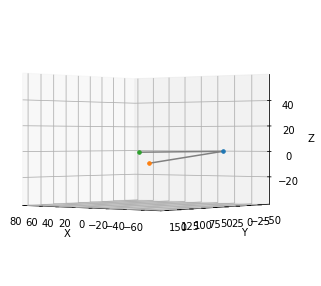

In [61]:
three_d_plotter = three_D_skeleton_plotter(points_dict, skeleton_dict=skeleton_dict, marker_size = 50, ax = None, 
                 marker_list=None, init_elev = 30, init_azim = 90, 
                 image_folder= Path('../../PCA_infill/3d_images/IBL'))
three_d_plotter(skeleton_data_sources=["pca"])

In [296]:
np.nanmax(points_dict["pca"]["paw_l"][174:178,:],axis=0)

array([45.69048718, 19.81479643, 11.16768561])

In [236]:
three_d_plotter.lims_dict

{'x': [-75.41319943606509, 18.601339054013557],
 'y': [-66.7203080170497, 155.6491750021465],
 'z': [-57.6659285838576, 60.63029406221289]}

In [223]:
collapsed_list = three_d_plotter.collapse_dict()

In [226]:
collapsed_list.shape

(3, 1200)

In [210]:
mins = np.array([-1., -3., -7.])
maxs = np.array([1., 2., -2.])
np.abs(mins)
np.abs(maxs)
np.max(np.concatenate([np.abs(mins), np.abs(maxs)], axis=0))

7.0

In [216]:
np.max(np.stack([np.abs(mins), np.abs(maxs)], axis=0), axis=0)

array([1., 3., 7.])

In [33]:
def initialize_skeleton(skeleton):
    """ Initialize the skeleton from input data.
    Takes in either a .csv or .xlsx file and makes a DataFrame.
    Parameters
    ----------
    skeleton: pandas.DataFrame
        Filepath of the .csv or .xlsx file that has indexed information
        on name of the keypoint (part, e.g. head), parent (the direct
        connecting part, e.g. neck connects to head, parent is head),
        and swap (swapping positions with a part when reflected over X).
    """

    if isinstance(skeleton, str):
        if skeleton.endswith(".csv"):
            skeleton = pd.read_csv(skeleton)
        elif skeleton.endswith(".xlsx"):
            skeleton = pd.read_excel(skeleton)
        else:
            raise ValueError("skeleton must be .csv or .xlsx file")
    elif isinstance(skeleton, pd.DataFrame):
        skeleton = skeleton
    else:
        raise TypeError("skeleton must be type `str` or pandas.DataFrame")

    if "name" not in skeleton.columns:
        raise KeyError("skeleton file must contain a `name` column")
    elif "parent" not in skeleton.columns:
        raise KeyError("skeleton file must contain a `parent` column")

    if "x" not in skeleton.columns:
        skeleton["x"] = -1
    if "y" not in skeleton.columns:
        skeleton["y"] = -1

    if "tree" not in skeleton.columns:
        skeleton["tree"] = -1
        for idx, name in enumerate(skeleton["parent"].values):
            branch = np.where(skeleton["name"] == name)[0]
            if branch.shape[0] > 0:
                branch = branch[0]
                skeleton.loc[idx, "tree"] = branch
    if "swap_index" not in skeleton.columns:
        skeleton["swap_index"] = -1
        for idx, name in enumerate(skeleton["name"].values):
            for jdx, swap_name in enumerate(skeleton["swap"].values):
                if swap_name == name:
                    skeleton.loc[idx, "swap_index"] = jdx
    return skeleton


In [35]:
skeleton_filename = '../../Video_Datasets/Sawtell-data/tank_skeleton_4.csv'
os.path.isfile(skeleton_filename)

True

In [36]:
skeleton = initialize_skeleton(skeleton_filename)
graph = skeleton[["tree", "swap_index"]].values[:,0]

In [38]:
print(graph)
print("==========")
for idx, node in enumerate(graph):
    print(idx, node)

[ -1   0   1   2   3   4   0  10   6   8   9   8   8   7   7   0  15   0
  17   6  19   6  21  -1  23  24  25  26  27  23  33  29  31  32  31  31
  30  30  23  38  23  40  29  42  29  44  -1  46  47  48  49  50  46  56
  52  54  55  54  54  53  53  46  61  46  63  52  65  52  67  -1  69  70
  71  -1  73  74  75  -1  77  -1  79  -1  81  82  83  84  -1  86  87  88
  89  -1  91  92  93  94  -1  96  97  98  -1 100 101 102  -1 104 105 106]
0 -1
1 0
2 1
3 2
4 3
5 4
6 0
7 10
8 6
9 8
10 9
11 8
12 8
13 7
14 7
15 0
16 15
17 0
18 17
19 6
20 19
21 6
22 21
23 -1
24 23
25 24
26 25
27 26
28 27
29 23
30 33
31 29
32 31
33 32
34 31
35 31
36 30
37 30
38 23
39 38
40 23
41 40
42 29
43 42
44 29
45 44
46 -1
47 46
48 47
49 48
50 49
51 50
52 46
53 56
54 52
55 54
56 55
57 54
58 54
59 53
60 53
61 46
62 61
63 46
64 63
65 52
66 65
67 52
68 67
69 -1
70 69
71 70
72 71
73 -1
74 73
75 74
76 75
77 -1
78 77
79 -1
80 79
81 -1
82 81
83 82
84 83
85 84
86 -1
87 86
88 87
89 88
90 89
91 -1
92 91
93 92
94 93
95 94
96 -1
97 96


In [9]:
# lines
for idx, node in enumerate(graph):
    if node >= 0:
        pt1 = keypoints[idx]
        pt2 = keypoints[node]
        if pt1[-1]>confidence_thresh and pt2[-1]>confidence_thresh:
            cv2.line(frame, (int(pt1[0]), int(pt1[1])), (int(pt2[0]), int(pt2[1])), (0, 0, 255), 1, cv2.LINE_AA)

'a b'

below we extract dicts of the desired form for our class.


In [62]:
data_sources = list(file["left"].keys())[1:] # assuming same sources for the "right view"?
print(data_sources)
views = list(file.keys())
print(views)

points = {}
for d in data_sources:
    points[d] = {}
    for v in views:
        points[d][v] = dict(file[v][d])

frames = {}
for v in views:
    frames[v] = file[v]["images"]

#points = []
#for i in vi

['predictions', 'reprojections']
['left', 'right']


In [48]:
for idx, name in enumerate(skeleton_dict["name"]):
    print(instance.points["reprojections"]["right"][name])

<HDF5 dataset "nose_tip": shape (400, 2), type "<f4">
<HDF5 dataset "paw_l": shape (400, 2), type "<f4">
<HDF5 dataset "paw_r": shape (400, 2), type "<f4">


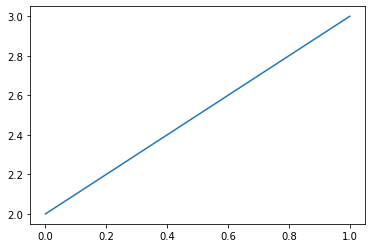

In [49]:
plt.plot([0,1], [2,3])

In [55]:
instance.points["reprojections"]["right"][name]

<HDF5 dataset "paw_r": shape (400, 2), type "<f4">

In [60]:
def to_xy_coords(pt1, pt2):
    '''converts [(x_1, y_1), (x_2, y_2)] --> ([x_1, x_2), (y_1, y_2)]'''
    x = np.array([pt1[0], pt2[0]])
    y = np.array([pt1[1], pt2[1]])
    return (x,y)

In [76]:
a = ()
a.append(2)

AttributeError: 'tuple' object has no attribute 'append'

In [84]:
def pts_to_coords(pt1, pt2):
    '''converts [(x_1, y_1), (x_2, y_2)] --> ([x_1, x_2), (y_1, y_2)]
    supports a third coordinate if it appears.'''
    assert(pt1.shape == pt2.shape)
    keys = ["x", "y"]
    if pt1.shape[0] == 3: # append a third coordinate
        keys.append("z")
    coord_dict = {}
    for i in range(pt1.shape[0]):
        coord_dict[keys[i]] = np.array([pt1[i], pt2[i]])
    return coord_dict

In [82]:
to_xy_coords(np.array([1., 2., 3.]), np.array([1., 2., 3.]))

{'x': array([1., 1.]), 'y': array([2., 2.]), 'z': array([3., 3.])}

In [ ]:
#in 2d, skeleton_dict should have entries per view skeleton_dict["view"][...]

The folder already exists at: ../../PCA_infill/images/IBL


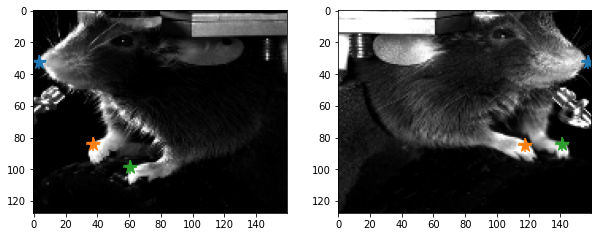

In [67]:
instance = Tracking_Video_Generator(frames, 
                                    points, 
                                    marker_list=['+', '*'], 
                                    marker_size= 200, 
                                   image_folder = image_folder)
instance.show_images(10)
instance.scatter_points(10)

In [66]:
instance.show_images(10)
instance.scatter_points(10)

TypeError: 'AxesSubplot' object is not iterable

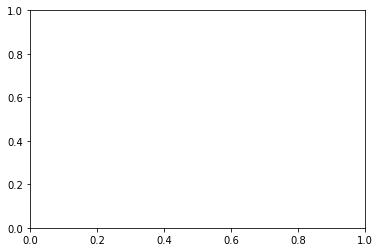

In [84]:
fig, ax = plt.subplots(1,1)
[print(a) for a in ax]

The folder already exists at: ../../PCA_infill/images/IBL


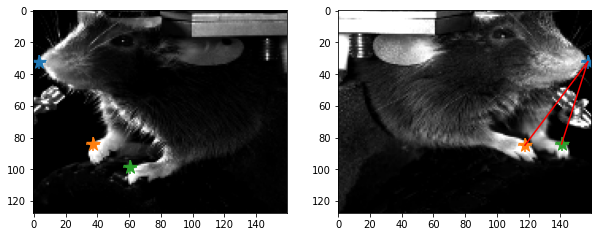

In [85]:
instance = Tracking_Video_Generator(frames, 
                                    points, 
                                    marker_list=['+', '*'], 
                                    marker_size= 200, 
                                   image_folder = image_folder)
instance.show_images(10)
instance.scatter_points(10)
# TODO: generalize and put inside videogenerator class
for idx, name in enumerate(skeleton_dict["name"]):
    if skeleton_dict["parent"][idx] is not None:
        name = instance.points["reprojections"]["right"][name][10,:]
        parent = instance.points["reprojections"]["right"][skeleton_dict["parent"][idx]][10,:]
        coord_dict = pts_to_coords(name, parent)
        instance.ax[1].plot(coord_dict["x"],
                           coord_dict["y"], 
                            'red', 
                           marker = None, zorder=10)
#print(instance.marker_list)

In [23]:
instance(video_name=None)

  0%|          | 0/400 [00:00<?, ?it/s]

Matt's function below. test it and borrow ideas.
* having "left"/"right" may not be the best idea? if we have e.g., 6 views, should we call them by name? or just have a list of length 6? Matt: keep the dict structure, it's the most general, and forces us to maintain order.
* downside to the work with `matplotlib.animation`: say you want to add the 3d reconstructions. and you want to have a separate class that does that.
* points a dict of dict: `["data_source"]["view"]["bp_name"]`
* higher level function that creates dirs, subdirs, saves images, concatanates images, makes videes.

to generate points in matt's format, we do as follows:

In [21]:
instance.vid_from_images('bla.mp4')

ffmpeg -r 2 -i ../../PCA_infill/images/IBL/im_%04d.jpg -vcodec libx264 -crf 25 bla.mp4


In [25]:

cmd = "/Users/danbiderman/miniconda3/envs/3d-pose/bin/ffmpeg -r 2 -i images/IBL/im_%04d.jpg -vcodec libx264 -crf 25 bla.mp4"
os.system(cmd)

256

In [ ]:
cmd = string.join(["ffmpeg -r 2 -i", \
                     os.path.join(str(self.image_folder), \
                                  'im_%04d.{}'.format(self.image_type)), \
                    "-vcodec libx264 -crf 25", \
                    video_name])
        print(cmd)
        #cmd = "ffmpeg -r 2 -i images/IBL/im_%04d.jpg -vcodec libx264 -crf 25 ibl_pca3_hard_frames_maha_9.mp4"
        os.system(cmd)

In [51]:
os.path.join(str(image_folder), "im_%04d.jpg")
str(image_folder).split('/')[:-2]

['..', '..', 'PCA_infill']

In [12]:
import sys
sys.path

['/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/Paninski/3D-Animal-Pose/PPCA',
 '/Users/danbiderman/miniconda3/envs/3d-pose/lib/python39.zip',
 '/Users/danbiderman/miniconda3/envs/3d-pose/lib/python3.9',
 '/Users/danbiderman/miniconda3/envs/3d-pose/lib/python3.9/lib-dynload',
 '',
 '/Users/danbiderman/miniconda3/envs/3d-pose/lib/python3.9/site-packages',
 '/Users/danbiderman/miniconda3/envs/3d-pose/lib/python3.9/site-packages/IPython/extensions',
 '/Users/danbiderman/.ipython']

In [13]:
(
    ffmpeg
    .input(os.path.join(str(image_folder), "im_%04d.jpg"), pattern_type='glob', framerate=2)
    .output('../../PCA_infill/movie.mp4')
    .run()
)

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

In [32]:
file["left"].keys()

<KeysViewHDF5 ['images', 'predictions', 'reprojections']>

In [37]:
points["predictions"]["left"].keys()

dict_keys(['nose_tip', 'paw_l', 'paw_r'])

In [9]:
plot_folder / 'matt_vid.mp4'

PosixPath('../../PCA_infill/figs/IBL/matt_vid.mp4')

processing frame 000/400
processing frame 100/400
processing frame 200/400
processing frame 300/400
creating animation...done
saving video to ../../PCA_infill/figs/IBL/test_matt_vid.mp4...

PermissionError: [Errno 13] Permission denied: '/Users/danbiderman/miniconda3/pkgs/ffmpeg-4.2.2-h97e5cf8_0'

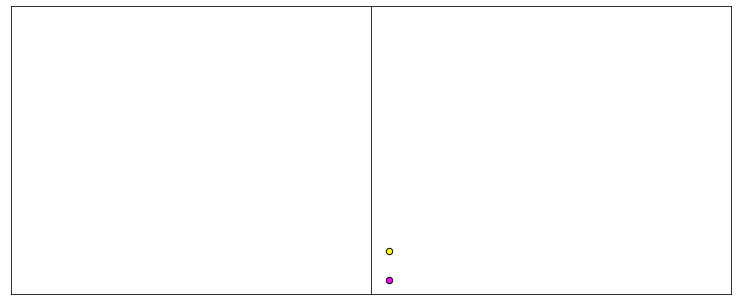

In [12]:
make_labeled_movie(plot_folder / 'test_matt_vid.mp4', frames, points)

In [166]:
str(strs)

"['', 'Users', 'danbiderman', 'miniconda3', 'envs']"

In [177]:
Path(sys.executable).as_posix().split('/')[:-1]

['', 'Users', 'danbiderman', 'miniconda3', 'envs', '3d-pose', 'bin']

In [180]:
import sys
from pathlib import Path
strs = Path(sys.executable).as_posix().split('/')[:-1]
separator = '/'
path_to_bin = separator.join(strs)
path_to_ffmpeg = os.path.join(path_to_bin, 'ffmpeg')
os.path.isdir(path_to_ffmpeg)
#os.path.join([s for s in strs])

False

In [14]:
plt.rcParams['animation.ffmpeg_path']
path_to_ffmpeg = '/Users/danbiderman/miniconda3/pkgs/ffmpeg-4.2.2-h97e5cf8_0'
os.path.isdir(path_to_ffmpeg)


True

In [ ]:
j, (point_dict, color) in enumerate(zip(points.keys(), colors)):
    print (j, (point_dict, color))

In [6]:
def make_labeled_movie(
        save_file, frames, points, titles=None, colors=None, framerate=20, height=4,
        frame_idxs_left_view=None, frame_idxs_right_view=None):
    """
    Parameters
    ----------
    save_file
    frames : dict
        keys are 'left', 'right'
    points : list of dicts
        each dict has keys 'left', 'right', values are themselves dicts with keys of marker names
        and vals of marker values, i.e. `points['left']['paw_l'].shape = (n_t, 2)`
    titles : list
    colors : list
    framerate : float
        framerate of video
    height : float
        height of movie in inches
    frame_idxs_left_view : array-like, optional
        if present, frame index of left view is printed in upper corner of left view
    frame_idxs_right_view : array-like, optional
        if present, frame index of right view is printed in upper corner of right view
    """
    plt.rcParams['animation.ffmpeg_path'] = '/Users/danbiderman/miniconda3/pkgs/ffmpeg-4.2.2-h97e5cf8_0' # super important line. should appear before matplotlib
    import matplotlib.animation as animation
    from matplotlib.animation import FFMpegWriter
    views = list(frames.keys())
    for point in points:
        if point is not None:
            marker_names = list(point[views[0]].keys())
            break
    n_frames = len(frames[views[0]])
    img_height, img_width = frames[views[0]][0].shape
    h = height
    w = 2 * h * (img_width / img_height)
    fig, axes = plt.subplots(1, 2, figsize=(w, h))
    plt.subplots_adjust(wspace=0, hspace=0, left=0, bottom=0, right=1, top=1)
    for ax, view in zip(axes, views):
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlim([0, img_width])
        ax.set_ylim([img_height, 0])
        ax.text(
            0.95, 0.05, '%s view' % view, fontsize=16, color=[1, 1, 1],
            horizontalalignment='right', verticalalignment='center',
            transform=ax.transAxes)
    im_kwargs = {'animated': True, 'vmin': 0, 'vmax': 255, 'cmap': 'gray'}
    txt_kwargs = {
        'fontsize': 16, 'color': [1, 1, 1], 'horizontalalignment': 'left',
        'verticalalignment': 'center', 'transform': axes[1].transAxes}
    frame_right_txt_kwargs = {
        'fontsize': 20, 'color': [0, 0, 0], 'horizontalalignment': 'left',
        'verticalalignment': 'center', 'transform': axes[0].transAxes,
        'bbox': dict(facecolor='white', edgecolor='black')}
    frame_left_txt_kwargs = {
        'fontsize': 20, 'color': [0, 0, 0], 'horizontalalignment': 'right',
        'verticalalignment': 'center', 'transform': axes[1].transAxes,
        'bbox': dict(facecolor='white', edgecolor='black')}
    styles = ['o', '^', 'P']
    if titles is None:
        titles = ['Original marker', 'Reprojected marker']
    if colors is None:
        colors = [[[1, 0, 1]], [[1, 1, 0]]]
        colors = [colors[k] for k in range(len(titles))]
    for i, (title, color) in enumerate(zip(titles, colors)):
        if title is not None:
            axes[1].text(0.08, 0.05 + 0.10 * i, title, **txt_kwargs)
            axes[1].scatter(
                0.05 * img_width, (0.95 - 0.10 * i) * img_height, s=40, c=color,
                edgecolors=[0, 0, 0])
    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ims = []
    for n in range(n_frames):
        if n % 100 == 0:
            print('processing frame %03i/%03i' % (n, n_frames))
        ims_curr = []
        for i, view in enumerate(views):
            # frames
            im = axes[i].imshow(frames[view][n], **im_kwargs)
            ims_curr.append(im)
            # markers
            for j, (point_dict, color) in enumerate(zip(points, colors)):
                if point_dict is not None:
                    for m, marker in enumerate(marker_names):
                        im = axes[i].scatter(
                            point_dict[view][marker][n, 0], point_dict[view][marker][n, 1],
                            s=40, c=color, edgecolors=[0, 0, 0], marker=styles[m])
                        ims_curr.append(im)
            # frame info
            if frame_idxs_right_view is not None and view == 'right':
                im = axes[0].text(
                    0.02, 0.95, 'Frame %i' % frame_idxs_right_view[n], **frame_right_txt_kwargs)
                ims_curr.append(im)
            if frame_idxs_left_view is not None and view == 'left':
                im = axes[1].text(
                    0.98, 0.95, 'Frame %i' % frame_idxs_left_view[n], **frame_left_txt_kwargs)
                ims_curr.append(im)
        ims.append(ims_curr)
    print('creating animation...', end='')
    ani = animation.ArtistAnimation(fig, ims, blit=True, repeat=False)
    print('done')
    print('saving video to %s...' % save_file, end='')
    writer = FFMpegWriter(fps=framerate, bitrate=-1)
    if not os.path.exists(os.path.dirname(save_file)):
        os.makedirs(os.path.dirname(save_file))
    ani.save(save_file, writer=writer)
    print('done')

In [121]:
ls_test = [1]
for i in range(len(ls_test)):
    print(i)
    print(ls_test[i])

0
1


(400, 128, 160)

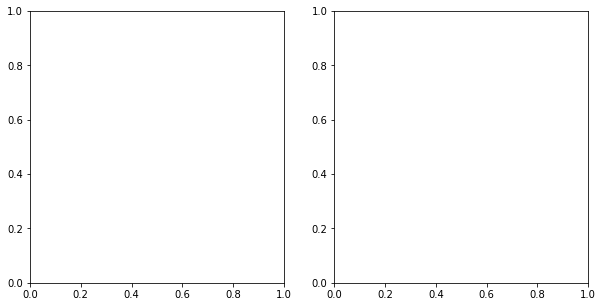

In [88]:
instance = Tracking_Video_Generator([np.asarray(file["right"]["images"]), file["left"]["images"]], [arr_for_test])
out = instance.check_images_list()
out[0].shape

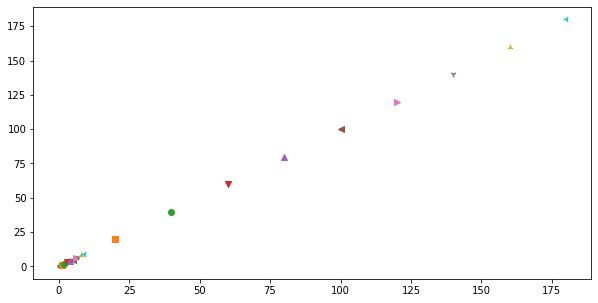

In [69]:
instance = Tracking_Video_Generator([file[view]["images"]], [arr_for_test])
for i in range(10):
    instance.ax.scatter(np.asarray([1.*i, 20.*i],dtype="float"), np.asarray([1.*i, 20.*i],dtype="float"), marker = list(matplotlib.markers.MarkerStyle.markers.keys())[i])

0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right


<ipython-input-47-e9c48ebed0cb>:65: UserWarning: No contour levels were found within the data range.
  ax[j].contour(x,y,d,[empirical_ds[j]], colors = color[bp], alpha=1.0)


0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
right
0
left
1
r

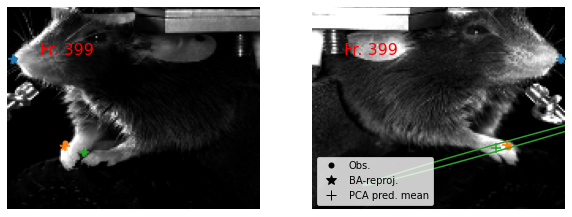

In [47]:
plot_all_covs = True
plot_mean_preds = True
plot_reprojections = True
ind_list = create_ind_list(int(arr_for_test.shape[0]/2))
# now plotting. for each frame and body part, pick the relevant covariances to show.
# mark the points by colors
# mark the missing points by missing circles
# In general we WANT to loop over bps here just to have colors for each
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax = ax.flatten()
for i in range(arr_for_test.shape[1]): # arr_for_test.shape[1], loop over frames, should be arr_for_test.shape[-1]
    for j, view in enumerate(view_names):
        print(j)
        print(view)
        ax[j].clear()
        ax[j].imshow(file[view]["images"][i,:,:], "gray", vmin=0, vmax=255)
        ax[j].axis('off')
        ax[j].text(x=20, y=30, s = 'Fr. %i' %i, color = 'red', fontsize = 16)
        
        for bp in range(arr_for_test.shape[-1]): # loop over body parts, should be arr_for_test.shape[0] 
            ax[j].scatter(arr_for_test[ind_list[j][0],i,bp].flatten(), 
                        arr_for_test[ind_list[j][1],i,bp].flatten(), 
                        color = color[bp],
                       marker = ".",
                         s=100,
                         label='data')
            if plot_reprojections:
                ax[j].scatter(file[view]["reprojections"][bodypart_names[bp]][i,0],
                             file[view]["reprojections"][bodypart_names[bp]][i,1],
                             color = color[bp],
                             marker = "*", 
                             s=100,
                             alpha=0.5, 
                             label='reproj')
    
            # if there are zero visible views, don't plot
            if np.sum(np.isnan(arr_for_test[:,i,bp].flatten()))==np.shape(arr_for_test)[0]:
                continue
            
            bp_covariance_all = preds_reshaped['cov'][:,:, i, bp]
            
            if plot_mean_preds:
                ax[j].scatter(preds_reshaped['mean'][ind_list[j][0],i,bp].flatten(), 
                            preds_reshaped['mean'][ind_list[j][1],i,bp].flatten(), 
                            color = color[bp],
                            marker = '+',
                             s=100, label="PCA pred. mean")
            if plot_all_covs:
                cov = LG_model.extract_blocks_from_inds(ind_list[j], bp_covariance_all)
                mean = preds_reshaped['mean'][ind_list[j],i,bp].reshape(-1,1)
                #plot_conf_ellipse(cov, mean, 0.95, color[bp],2)
                if np.sum(np.isnan(arr_for_test[:,i,bp].flatten()))>0:
                    #print("have more than zero nans")
                    grid_dev=800
                else:
                    grid_dev=25
    
                x,y,stacked = make_meshgrid(mean, 
                                            grid_dev, 
                                            allow_pred_outside=False, 
                                            im_size=file[view]["images"][i,:,:].shape)
                #print(np.min(x), np.max(x), np.min(y), np.max(y))
                #print(stacked.shape)
                d = mahalanobis_distance(cov=cov, mean=mean, stacked_meshgrid=stacked)
                ax[j].contour(x,y,d,[empirical_ds[j]], colors = color[bp], alpha=1.0)
    
    #plt.title('Prediction by first %i PCs, explained var=%.2f' % (num_PCs, np.sum(pca.explained_variance_ratio_[:num_PCs])))
    ax[j].legend(handles=legend_elements, loc = "lower left")
    fig.savefig(image_folder / ('im_%04d.jpg' %i)) # was png